## CONNEXION à la Base postgres et lecture de 3 jours de données

In [1]:
import pandas as pd
import matplotlib
import psycopg2

In [2]:
host="localhost"
port=5432
dbname="hmvl"
username="dirmed"
#pwd="votremotdepasse"

In [3]:
# mise à jour 29/04 : suppression des fichiers en doublon avant l'import en base,
# import 25,26,27 avril
# mise à jour 14/5 : import via csv plus rapide, la table log_imports n'est plus alimentée
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from hmvl;"
hmvl = pd.read_sql_query(sql, conn)
conn = None

In [4]:
hmvl["hdt"] = pd.to_datetime(hmvl["hdt"],utc=True)

## rapide examen des données

In [5]:
hmvl.dtypes

id                           int64
horodate_id                 object
hdt            datetime64[ns, UTC]
station                     object
status                      object
voie                        object
vitesse                    float64
longueur                   float64
statuttr                    object
dtype: object

In [6]:
print(hmvl["statuttr"].value_counts())
# a priori on garde les statuts B et @
# pour H que fait-on ? en principe c'est une erreur interne mais les valeurs ont l'air correctes
# de même pour J... et les autres valeurs ne sont pas documentées
# par exemple avec le statuttr J il n'y a aucune ligne avec le status 2
print(hmvl[(hmvl["status"]=="2") & (hmvl["statuttr"]=="J")])
# -> a priori le Status TR n'apporte pas d'info permettant d'éliminer des mesures
hmvl[hmvl["statuttr"]=="H"][:20]


B    2995816
@    1940697
H     431897
J     248979
4        483
1         65
b         62
I         21
          11
3          3
Name: statuttr, dtype: int64
Empty DataFrame
Columns: [id, horodate_id, hdt, station, status, voie, vitesse, longueur, statuttr]
Index: []


,id,horodate_id,hdt,station,status,voie,vitesse,longueur,statuttr
18,19,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:18+00:00,M1c,0,None,NaN,NaN,H
25,26,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:29.570000+00:00,M1b,0,0,115.0,5.4,H
26,27,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:29.800000+00:00,M1b,0,1,111.0,4.3,H
99,100,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:31.690000+00:00,M1h,0,0,113.0,3.2,H
100,101,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:34.510000+00:00,M1h,0,0,84.0,3.1,H
115,116,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:31.960000+00:00,M1B,0,1,84.0,3.9,H
154,155,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:18+00:00,M3x,0,None,NaN,NaN,H
165,166,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:31.690000+00:00,M7j,0,0,85.0,11.5,H
166,167,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:32.600000+00:00,M7j,0,1,101.0,4.4,H
167,168,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:33.240000+00:00,M7j,0,0,85.0,5.7,H


## On peut éliminer les données de status 2

In [28]:
print(hmvl["status"].value_counts())
# il reste 20% de données avec le status 2
# pour toutes les données avec le status 2 : voie est None, et longueur et vitesse sont Nan
hmvl[hmvl["status"]=="2"]["voie"].isna().sum()

0    5449199
2     609726
Name: status, dtype: int64


609726

#### on peut garder un dataframe status2 pour avoir les stats par station et par jour

In [85]:
#pas besoin de garder statuttr: pour status=2: statuttr=NULL
# on pourrait stocker en base dans une table le nb de status=2 par jour par station par jour
status2=hmvl[hmvl["status"]=="2"][["hdt","station"]]

In [86]:
status2=status2.assign(jour=pd.to_datetime(status2['hdt']).dt.to_period('D'))

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [87]:
status2.groupby(['jour','station']).count().sort_values(by='hdt')

hdt
jour       station      
2020-04-26 M4h         1
2020-04-27 M3s         1
           M3r         1
           M3p         1
           M3l         1
...                  ...
2020-04-25 M3m      8700
           M4e      8700
           M3S      8700
           M8Q      8700
           M3q      8700

[366 rows x 1 columns]

### On travaille maintenant avec les mesures status=0

In [88]:
hmvl=hmvl[hmvl["status"]=="0"][["id","hdt","station","voie","vitesse","longueur","statuttr"]]
# 5,4 M de mesures pour 3 jours

### On peut éliminer les mesures qui voie=NULL

In [97]:
print(hmvl["longueur"].isnull().sum())
print(hmvl["vitesse"].isnull().sum())
print(hmvl["voie"].isnull().sum())
print(hmvl[(hmvl["voie"].isnull()) & (hmvl["vitesse"].isnull()) & (hmvl["longueur"].isnull())].count())
# pour les données de status 0 (Ok) il y a 20% de mesures vides
# quand voie est NULL, vitesse et longueur sont aussi NULL (ce qui est cohérent)
# donc on peut supprimer toutes les mesures pour lesquelles voies est nulles

1254331
1282532
1111792
id          1111792
hdt         1111792
station     1111792
voie              0
vitesse           0
longueur          0
statuttr    1111792
dtype: int64


In [100]:
sansvoie=hmvl[hmvl["voie"].isna()][["hdt","station","statuttr"]]

In [112]:
sansvoie=sansvoie.assign(jour=pd.to_datetime(sansvoie['hdt']).dt.to_period('D'))

/home/patgendre/miniconda3/envs/hmvl/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [123]:
sansvoie.groupby(['jour']).count()
# à voir si les mesures vides sont liées au jour, le 26 en a plus (550k) que le 27 (240k) alors que c'est un dimanche

,hdt,station,statuttr
jour,,,
2020-04-25,330408,330408,330408
2020-04-26,536420,536420,536420
2020-04-27,244964,244964,244964


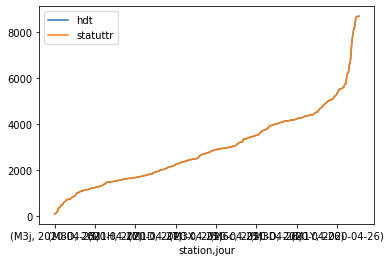

In [121]:
sansvoie.groupby(['station','jour']).count().sort_values(by='hdt').plot()
# comme pour les stations en status=2, certaines stations posent plus de problèmes, 
# mais beaucoup de stations ont plus de 1000 mesures vides par jour
# à jour si les stations sont toutes sur le même axe auquel cas ça pourrait être lié aux transmissions

### On travaille maintenant avec les mesures status=0

In [107]:
hmvl=hmvl[hmvl["voie"].notna()][["id","hdt","station","voie","vitesse","longueur","statuttr"]]
# restent 4,3 M de mesures pour 3 jours

In [108]:
len(hmvl)

4337407

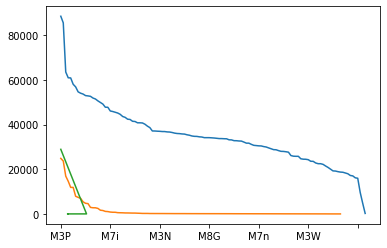

In [125]:
hmvl["station"].value_counts().plot()
hmvl[hmvl["vitesse"].isna()]["station"].value_counts().plot()
hmvl[hmvl["vitesse"].isna()]["longueur"].value_counts().plot()
# Il reste quelaques (une dizaine de stations) avec des vitesses ou longueurs vides
# là aussi on pourrait calculer un indicateur par station et par jour
# et le stocker en base


In [127]:
hmvl["hdt"].min() , hmvl["hdt"].max(), hmvl["hdt"].max()-hmvl["hdt"].min()
# les horodates sont OK mais attention on est en UTC donc la journée commence la veille à 22H en heures d'été
#hmvl["hdt"].tz_convert('Europe/Paris')

(Timestamp('2020-04-25 06:31:12.200000+0000', tz='UTC'),
 Timestamp('2020-04-27 21:02:05.970000+0000', tz='UTC'),
 Timedelta('2 days 14:30:53.770000'))

In [13]:
hmvl["hdt"].dt.date.value_counts()

2020-04-27    2762120
2020-04-25    1881000
2020-04-26    1583142
2020-04-24       1498
Name: hdt, dtype: int64

In [14]:
listedates=hmvl["horodate_id"].str[:10]
listedates.value_counts()
# les dates labocom sont au format AAAA-MM-JJ, les dates RD sont au format Day Mon DD

Mon Apr 27    2733253
Sat Apr 25    1786506
Sun Apr 26    1539166
2020-04-25      94292
2020-04-26      44629
2020-04-27      29914
Name: horodate_id, dtype: int64

In [35]:
len(hmvl[pd.isna(hmvl["status"])])+len(hmvl[hmvl["status"]=="0"])-len(hmvl["status"])

0

In [19]:
hmvl2=hmvl[hmvl["status"]=="0"][["id","hdt","station","voie","vitesse","longueur"]]
# en fait hmvl2 correspond aux seuls données VRU car pour les Labocom le status est vide (pd.isna est True)

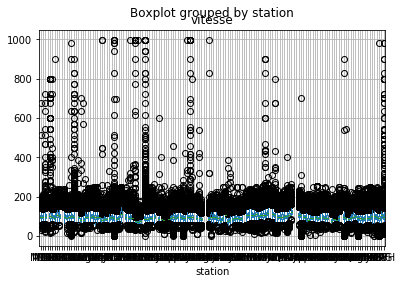

In [15]:
hmvl.boxplot(column=["vitesse"],by="station")
# ça semble raisonnable de prendre 280 (voire 240) comme valeur seuil de vitesse

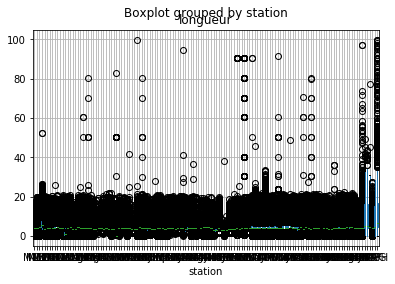

In [37]:
hmvl.boxplot(column=["longueur"],by="station")
# ça semble raisonnable de prendre 25 comme valeur seuil de longueur, 
# mais il y a peut être valeur plus pertinente pour le métier, à cause des Transports Exceptionnels par exemple?
# ou pour voir passer les convois ITER s'ils empruntent le réseau DIRMED?

In [17]:
print(hmvl['voie'].value_counts())
# cette fonction n'affiche pas les valeurs vides mais il y en a (1,7M)
# cf. hmvl2['voie'].unique()
sum(pd.isna(hmvl['voie']))

0    1767712
1    1516742
2     746664
3     300751
4     142378
5      27411
Name: voie, dtype: int64


1726102

In [18]:
len(hmvl)
# 6,2 M de lignes pour 3 jours de hmvl

6227760

In [17]:
 len(hmvl2)

908994

In [19]:
hmvl.shape

(6227760, 9)

In [20]:
sum(pd.isna(hmvl['voie']))
# 1,7M sur 6,2M mesures n'ont pas de voie dont sont inutilisables

1726102

135

634902

In [22]:
M8i=hmvl[hmvl["station"]=="M8i"]
M8i.head(5)

,id,horodate_id,hdt,station,status,voie,vitesse,longueur,statuttr
149,150,Sat Apr 25 08:40:18 2020,2020-04-25 06:40:18+00:00,M8i,0,None,NaN,NaN,B
336,337,Sat Apr 25 08:40:24 2020,2020-04-25 06:40:36.300000+00:00,M8i,0,0,81.0,3.6,B
337,338,Sat Apr 25 08:40:24 2020,2020-04-25 06:40:36.540000+00:00,M8i,0,2,NaN,NaN,B
522,523,Sat Apr 25 08:40:30 2020,2020-04-25 06:40:30+00:00,M8i,0,None,NaN,NaN,B
715,716,Sat Apr 25 08:40:36 2020,2020-04-25 06:40:36+00:00,M8i,0,None,NaN,NaN,B


In [23]:
len(M8i["hdt"])
# nb de mesures dans la journée

56638

### RECHERCHE DES DOUBLONS

In [24]:
idu=hmvl.groupby("hdt")["id"].unique()
# sur 2,8M mesures, seulement 52092 correspondent à une seule horodate

In [26]:
idu.head(5)

hdt
2020-04-24 22:00:00+00:00           [1786507, 1804383]
2020-04-24 22:00:02.180000+00:00             [1842995]
2020-04-24 22:00:04.580000+00:00             [1864417]
2020-04-24 22:00:04.780000+00:00             [1864418]
2020-04-24 22:00:15.100000+00:00             [1864419]
Name: id, dtype: object

In [14]:
id_hv=hmvl.groupby(["hdt","station","voie"])["id"].unique()
id_hv.apply(len).value_counts()
# sur 1,8M mesures, il y désormais très peu de doublons, qui correspondent aux dates incorrectes, d'ailleurs?
# cf. ci-dessous mesures du 26/12 -> il faudrait donc vérifier dans le fichier (RD - pas possible dans le labocom)
# que l'horodate dans l'en-tête est bien à la date du jour à importer en base

1    1600029
2      64326
4         43
3         14
Name: id, dtype: int64

In [16]:

# lecture des logs pour comprendre d'où viennent les répliques
conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, username, pwd))
sql = "select * from log_imports;"
logs= pd.read_sql_query(sql, conn)
conn = None

In [12]:
def mesures_répliquées(i):
# afficher les mesures pour une ligne de id_hv
    for x in id_hv.iloc[i]:
        fichier=logs[(logs['firstid']<=x) & (logs['lastid']>=x)].iloc[0]['fichier'][17:]
        print (fichier)
        print (hmvl2[hmvl2["id"]==x][["id","hdt","voie","vitesse","longueur"]])


In [22]:
mesures_répliquées(565)
# après utilisation de duplicates.py pour supprimer les fichiers en doublon :  plus de doublons dans le dataframe

ocom/09_MPH_1.csv
Empty DataFrame
Columns: [id, hdt, voie, vitesse, longueur]
Index: []


In [23]:
id_hv.head()

hdt                               station  voie
2020-04-01 22:00:00.300000+00:00  MPH      2                [3069332]
2020-04-01 22:00:00.890000+00:00  MPG      0                [2731256]
2020-04-01 22:00:01.230000+00:00  MBS      2       [3033582, 3434455]
2020-04-01 22:00:01.380000+00:00  MPB      2                [3222253]
2020-04-01 22:00:02.530000+00:00  MPF      0                [3305511]
Name: id, dtype: object

In [24]:
sansdouble=hmvl2.groupby(["hdt","station","voie"])

In [25]:
len(sansdouble)

776010

In [26]:
len(hmvl2)
# il reste des doublons!

841365

In [28]:
type(sansdouble)
# DataFrameGroupBy type
#sansdouble.groups est un dict de triplets hdt,station,voie

pandas.core.groupby.generic.DataFrameGroupBy

In [33]:
sansdouble.size().sort_values()

hdt                               station  voie
2020-04-02 12:29:22.840000+00:00  M8k      0       1
2020-04-02 13:23:14.640000+00:00  M4m      0       1
2020-04-02 13:23:14.740000+00:00  M3i      0       1
                                  M5f      3       1
2020-04-02 13:23:14.790000+00:00  M7i      0       1
                                                  ..
2020-04-02 06:02:58.810000+00:00  M8O      0       4
2020-04-02 06:10:22.560000+00:00  M8n      1       4
2020-04-02 06:24:00.500000+00:00  M7i      0       4
2020-04-02 06:16:24.210000+00:00  M3j      4       4
2020-04-02 06:12:49.750000+00:00  M8G      0       4
Length: 694818, dtype: int64

In [35]:
sansdouble.get_group(('2020-04-02 06:12:49.750000+00:00','M8G','0'))
# on a encore des doublons, exemple 2 fois les mêmes mesures v,l, 2 fois des mesures différentes?

,id,hdt,station,voie,vitesse,longueur
1576712,3883723,2020-04-02 06:12:49.750000+00:00,M8G,0,77.0,7.7
1589568,3896579,2020-04-02 06:12:49.750000+00:00,M8G,0,120.0,5.5
1700672,4054958,2020-04-02 06:12:49.750000+00:00,M8G,0,77.0,7.7
1713521,4067807,2020-04-02 06:12:49.750000+00:00,M8G,0,120.0,5.5


In [49]:
len(hmvl),len(hmvl2),len(sansdouble)

(1837914, 841365, 776010)

In [41]:
type(hmvl['hdt'])
type(hmvl['hdt'].loc[1])

pandas._libs.tslibs.timestamps.Timestamp

In [38]:
type(hmvl)

pandas.core.frame.DataFrame

In [42]:
hmvl['datetime'] = pd.to_datetime(hmvl['hdt'])
# Set the datetime column as the index
hmvl.index = hmvl['hdt'] 

In [45]:
v6=hmvl['vitesse'].resample('6T').mean() 
qv6=hmvl['vitesse'].resample('6T').count()
l6=hmvl['longueur'].resample('6T').mean()
ql6=hmvl['longueur'].resample('6T').count()
# calcul naïf de l'agrégation 6 minutes
# le débit n'est pas le même selon qu'on prend en compte les vitesses non vides ou les longueurs non vides
# on pourrait facilement renvoyer ça dans un table t6m

In [46]:
v6,qv6,l6,ql6

(hdt
 2020-04-01 22:00:00+00:00     94.267624
 2020-04-01 22:06:00+00:00     95.419825
 2020-04-01 22:12:00+00:00     94.747619
 2020-04-01 22:18:00+00:00     95.798387
 2020-04-01 22:24:00+00:00     94.212851
                                 ...    
 2020-04-03 14:54:00+00:00     98.070136
 2020-04-03 15:00:00+00:00    100.558753
 2020-04-03 15:06:00+00:00    100.552463
 2020-04-03 15:12:00+00:00    100.022936
 2020-04-03 15:18:00+00:00     98.719298
 Freq: 6T, Name: vitesse, Length: 414, dtype: float64,
 hdt
 2020-04-01 22:00:00+00:00    766
 2020-04-01 22:06:00+00:00    686
 2020-04-01 22:12:00+00:00    630
 2020-04-01 22:18:00+00:00    744
 2020-04-01 22:24:00+00:00    747
                             ... 
 2020-04-03 14:54:00+00:00    442
 2020-04-03 15:00:00+00:00    417
 2020-04-03 15:06:00+00:00    467
 2020-04-03 15:12:00+00:00    436
 2020-04-03 15:18:00+00:00    285
 Freq: 6T, Name: vitesse, Length: 414, dtype: int64,
 hdt
 2020-04-01 22:00:00+00:00    11.230949
 2020-04-01 

In [51]:
# conclusion provisoire : faire une procédure pour chaque jour
# 0. vérifier qu'il n'y a pas d'horodate différentes de la date du jour (attention à la timezone de Paris)
# 1. re-tester les doublons, il ne devrait plus y en avoir
# 2. supprimer les valeurs aberrantes de l et v, et les voies, longueur ou vitesse vides
# 3. agréger les données
# PS il faut aussi faire un diagnostic sur le taux de mesures valides par station